# Take-Home Challenge: Ultimate Data Science Challenge

### In this Challenge we will be looking at user and toll data for the cities Gotham and Metropolis.  A brief synopsis of the Challenge can be found here:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
### We will examine the provided data, cleaning it as well as conducting visualization analysis to look for any trends that may be useful for future feature engineering.  Then we will do some statistical testing on our data based on the hypothesis for this project, create our target feature and run our baseline model.  Based on the results of that baseline model we will then run further models and interpret and present our findings.

#### I will perform this all in one Jupyter notebook for simplicity and for ease of use.  The results will be posted in its according section, with Part 3 at the bottom of the notebook.  Let's get started.

#### As we do with every first step let's read in our data and start by importing some starter libraries to get this exercise off the ground.  We will add to this library list as we go, updating the list to the cell just below here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json



In [2]:
# Now let's read in our data files.  They are of json type, so we have to add a few steps to convert to dataframes.
file_path = 'logins.json'

with open(file_path, 'r') as f:
    data = json.load(f)

logins_df = pd.DataFrame(data)

print(logins_df.head())


            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21


In [3]:
# Now the other file, this one has quite a few more features and data in it.
file_path_ult = 'ultimate_data_challenge.json'

with open(file_path_ult, 'r') as f:
    data_ult = json.load(f)

ult_df = pd.DataFrame(data_ult)

print(ult_df.head())

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

#### Good now let's to some summary review on each of our new dataframes to get an idea of what we are working with.

In [4]:
# Let's look at the logins_df first.
logins_df.shape

(93142, 1)

In [5]:
logins_df.isna().sum()

login_time    0
dtype: int64

In [6]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3


## Part 1: Exploratory Data Analysis

#### This dataframe just has one feature in the login_time but it is an important one as this login_time will be used for the entirety of the exercise.  What I don't think we will need though is the actual time stamp.  Let's strip that and keep the date simplified as that is more important for our analysis.  Optional but then let's rename the feature to login_date.  Before we do that though part of the exercise instructions were to do the following: 

Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand.  Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

#### Let's do that now before we normalize this feature.

In [7]:
# First let's convert our login_time to datetime for usage.
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df.set_index('login_time', inplace = True)

In [8]:
# Now we assign our pandas resampling task to a new variable for the 15-minute intervals.
login_counts_15min = logins_df.resample('15min').size().reset_index(name = 'login_counts')
print(login_counts_15min.sample(10))

              login_time  login_counts
7118 1970-03-16 23:30:00            24
69   1970-01-02 13:15:00             5
9607 1970-04-11 21:45:00            22
5207 1970-02-25 01:45:00             9
7556 1970-03-21 13:00:00            14
115  1970-01-03 00:45:00            17
9025 1970-04-05 20:15:00             8
8784 1970-04-03 08:00:00             2
2928 1970-02-01 08:00:00             0
2352 1970-01-26 08:00:00             0


#### Let's also make a count variable for each day, hour, week, and month.  We will then plot them to look for any interesting trends we can see based on these login counts.

In [9]:
# Make the variable for login counts per hour.
login_counts_hour = logins_df.resample('h').size().reset_index(name = 'login_counts')
print(login_counts_hour.sample(10))

              login_time  login_counts
1634 1970-03-10 22:00:00            55
1418 1970-03-01 22:00:00            53
2441 1970-04-13 13:00:00            20
2356 1970-04-10 00:00:00            74
1829 1970-03-19 01:00:00           110
520  1970-01-23 12:00:00            63
2215 1970-04-04 03:00:00           150
1836 1970-03-19 08:00:00            10
1962 1970-03-24 14:00:00            14
38   1970-01-03 10:00:00             7


In [10]:
# Make the variable for login counts per day.
login_counts_day = logins_df.resample('D').size().reset_index(name = 'login_counts')
print(login_counts_day.sample(10))

   login_time  login_counts
1  1970-01-02           681
40 1970-02-10           590
4  1970-01-05           459
70 1970-03-12           827
98 1970-04-09           818
24 1970-01-25           852
97 1970-04-08           698
26 1970-01-27           565
88 1970-03-30           704
6  1970-01-07           648


In [11]:
# Now the variable count for week.
login_counts_week = logins_df.resample('W').size().reset_index(name = 'login_counts')
print(login_counts_week.sample(10))

   login_time  login_counts
5  1970-02-08          5572
2  1970-01-18          5023
8  1970-03-01          6554
0  1970-01-04          2374
4  1970-02-01          4744
11 1970-03-22          8955
7  1970-02-22          7035
6  1970-02-15          5915
3  1970-01-25          4751
9  1970-03-08          7398


In [12]:
# And finally login counts per month.
login_counts_month = logins_df.resample('ME').size().reset_index(name = 'login_counts')
print(login_counts_month)

  login_time  login_counts
0 1970-01-31         21239
1 1970-02-28         24673
2 1970-03-31         33723
3 1970-04-30         13507


#### Before we start plotting some of these I also want to make counts per each day of the week and for each hour of the day.

In [30]:
# Let's extract the day of the week data first
logins_df['day_of_week'] = logins_df.index.day_name()
logins_by_day_of_week = logins_df.groupby('day_of_week').size().reset_index(name = 'login_counts')

# Sort the days of the week to make output easier to read, we need to put the days in order.
# Will need to make a list of the dow's, create Categorical variables for them then sort accordingly.
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
logins_by_day_of_week['day_of_week'] = pd.Categorical(logins_by_day_of_week['day_of_week'], categories = days_order, ordered = True)
logins_by_day_of_week = logins_by_day_of_week.sort_values('day_of_week')

print(logins_by_day_of_week)

  day_of_week  login_counts
1      Monday          8823
5     Tuesday          9268
6   Wednesday         10339
4    Thursday         11960
0      Friday         15208
2    Saturday         19377
3      Sunday         18167


In [18]:
# And do the same for hour of the day.
logins_df['hour_of_day'] = logins_df.index.hour
logins_by_hour_of_day = logins_df.groupby('hour_of_day').size().reset_index(name = 'login_counts')

print(logins_by_hour_of_day)

    hour_of_day  login_counts
0             0          5993
1             1          6317
2             2          5800
3             3          4831
4             4          5034
5             5          2945
6             6          1138
7             7           815
8             8           818
9             9          1527
10           10          3064
11           11          5799
12           12          4964
13           13          3611
14           14          3426
15           15          3038
16           16          2832
17           17          2584
18           18          2980
19           19          3235
20           20          4103
21           21          5623
22           22          6607
23           23          6058


#### Great now let's look at some quick plots to see what is going on with our login counts.

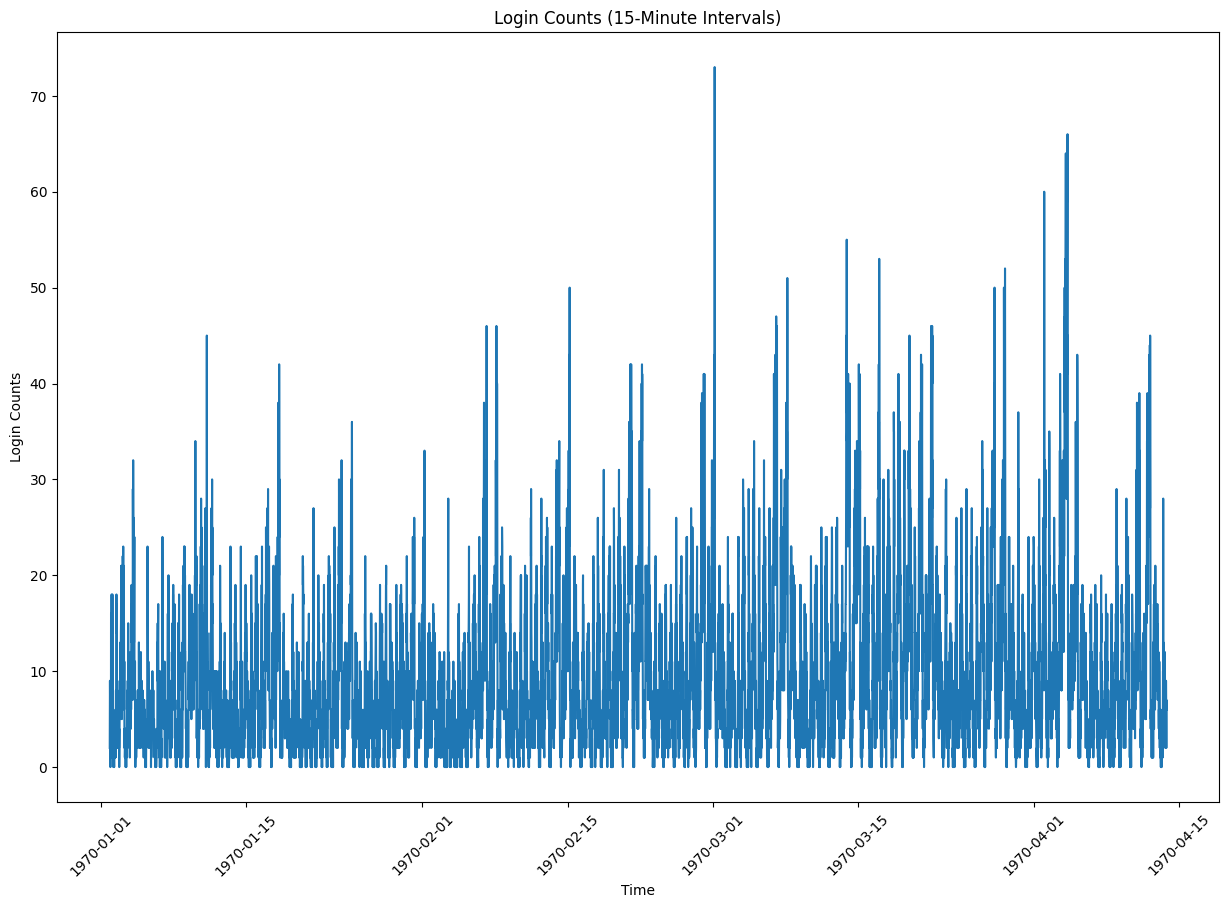

In [22]:
# First the 15min interval plot.
plt.figure(figsize = (15,10))
plt.plot(login_counts_15min['login_time'], login_counts_15min['login_counts'])
plt.title('Login Counts (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.xticks(rotation = 45)
plt.show()

#### Here above we can see 2 week time invervals and a rough cyclical pattern for our logins for the users.  This plot isn't as clear on our user login activity though, so we will look at some different intervals to see how this activity is better explained.

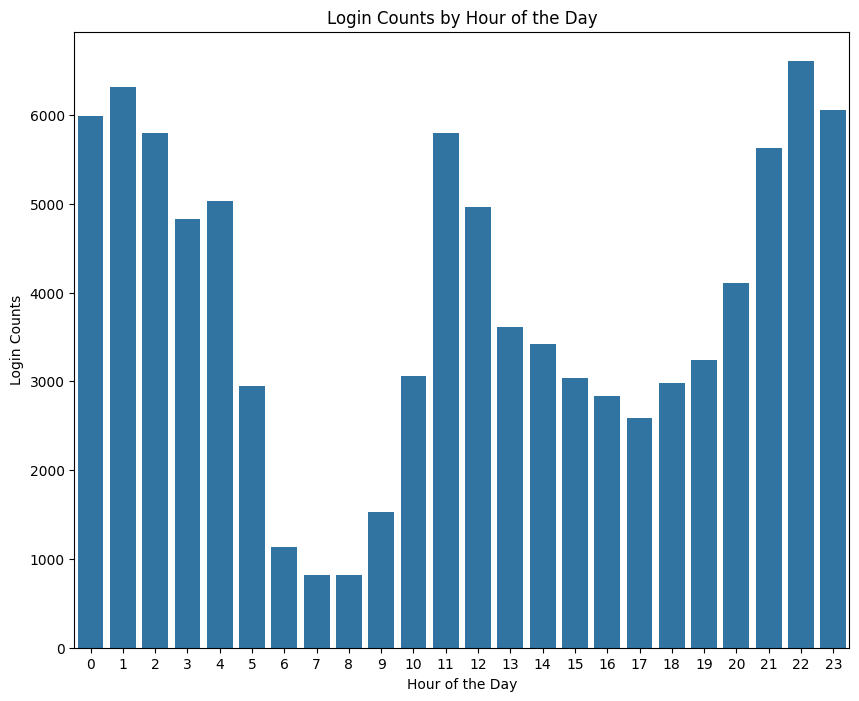

In [23]:
# PLot the user login activity by hour of the day.
plt.figure(figsize = (10,8))
sns.barplot(x = 'hour_of_day', y = 'login_counts', data = logins_by_hour_of_day)
plt.title('Login Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Login Counts')
plt.show()

#### This is a bit better, we can see that user login activity is highest in the middle of the night from 9pm - 5am then a slight spike around lunch time at 11am - 1pm.  Conversely the least amount of login usage is in the morning hours of 6am - 10am.  This is interesting.

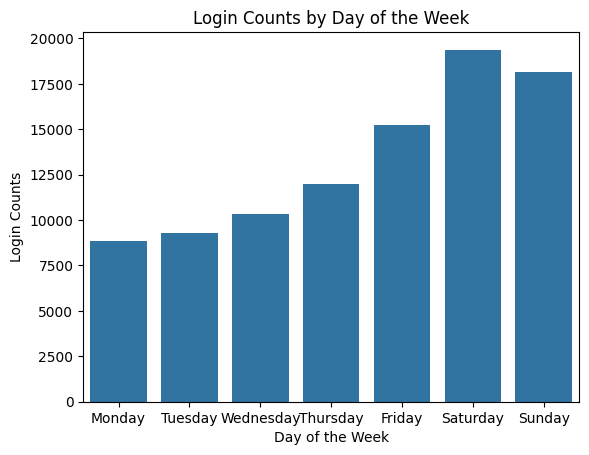

In [29]:
# Now let's plot by day of the week.
plt.plot(figsize = (10,8))
sns.barplot(x = 'day_of_week', y = 'login_counts', data = logins_by_day_of_week)
plt.title('Login Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Login Counts')
plt.show()

#### The bar plot above gives us another clear indicator of our user activity for the login data, telling us over this period that users tend to gradually login more over the course of the week as the week goes by.  The login data grows steadily starting with Monday and hits its peak on Saturday.

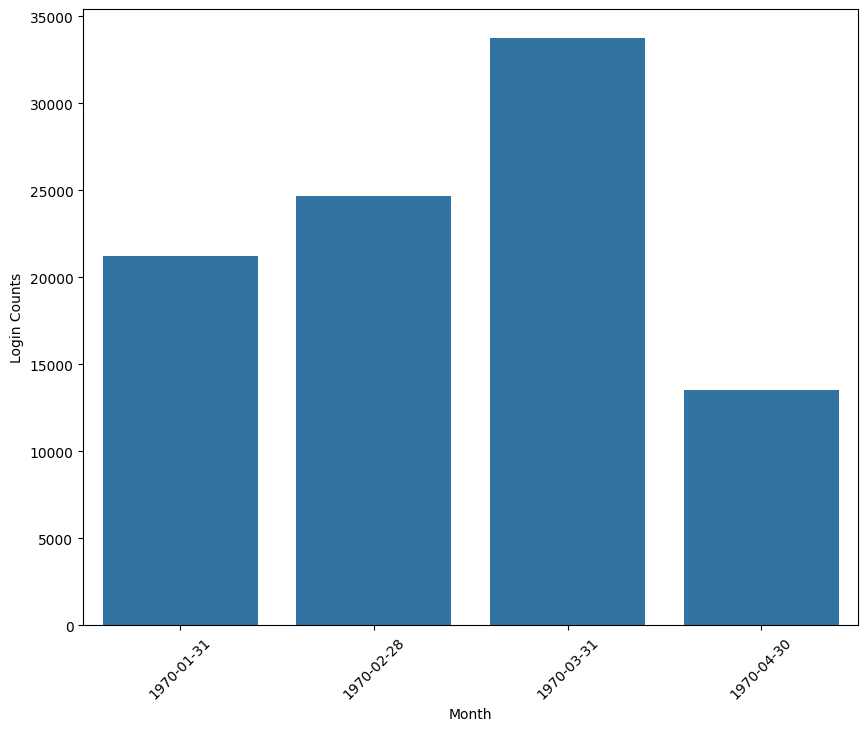

In [32]:
# lets's look at count for each month.
plt.figure(figsize = (10,8))
sns.barplot(x = login_counts_month['login_time'], y = login_counts_month['login_counts'])
title = ('Monthly Login Counts')
plt.xlabel('Month')
plt.ylabel('Login Counts')
plt.xticks(rotation = 45)
plt.show()


#### Now this is interesting, you have a clear picture of the login activity and count increasing from January (first month above) through March, then sharply decreasing in the representative count in April.  Why is this?  Let's keep this in mind as we move along as we work on solving the business problem assigned.

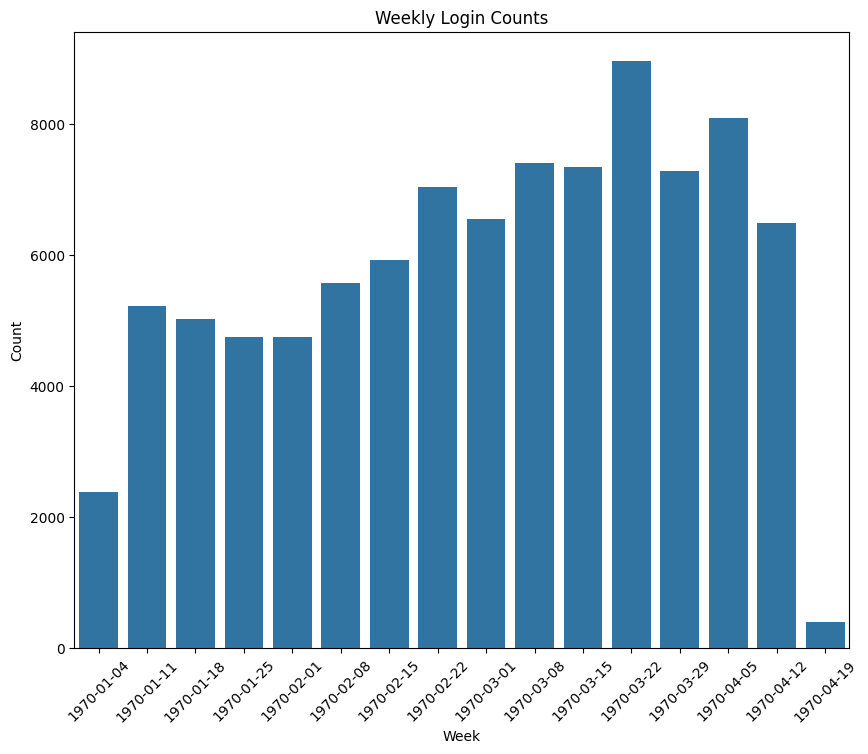

In [34]:
plt.figure(figsize = (10,8))
sns.barplot(x = login_counts_week['login_time'], y = login_counts_week['login_counts'])
plt.title('Weekly Login Counts')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### There aren't as many discernible trends in the by-week plot above, however the drop off for login count is much more noticeable here from 04-12 to 04-19 weeks.  Very drastic volume difference.

## Part 1 Summary:
#### We have explored the login data, reading in the json file and converting to a dataframe.  We have looked for missing values (there wasn't any), and then as requested counted logins based on a 15-minute interval and visualized.  Since no real discernible inference was made there we looked at other intervals and noticed the following based on the data presented:

#### -Users had the most login activity on Saturday and Sunday during the week.
#### -Users demonstrated increasing login activity each month from January through March in the data supplied, however there was a sharp decrease in activity in April's reported login data.  This is recommended to be looked into as to why that is.
#### -Users logged in the most during the hours of 9pm - 5am with another spike during lunchtime of 11am - 1pm, and they logged in the least between 6am - 10am.

#### Great, now let's continue with normal operations for normalizing the login file as well as cleaning the other file.

In [8]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time']).dt.normalize()
logins_df = logins_df.rename(columns = {'login_time' : 'login_date'})
logins_df.sample(10)

,login_date
36231,1970-02-19
77983,1970-03-29
65300,1970-03-19
20688,1970-01-31
21974,1970-02-01
55080,1970-03-09
87340,1970-04-07
67918,1970-03-20
50464,1970-03-06
22690,1970-02-02


#### Good, now let's move on to the other file.  We will take the same actions though will likely have more to do with that one.

In [9]:
ult_df.shape

(50000, 12)

In [10]:
ult_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

#### Alright so we have several features that are missing some values, most notably the avg_rating_of_driver feature.  Let's check out at least two of these as since 'phone' is categorical we can fix that one pretty easily.

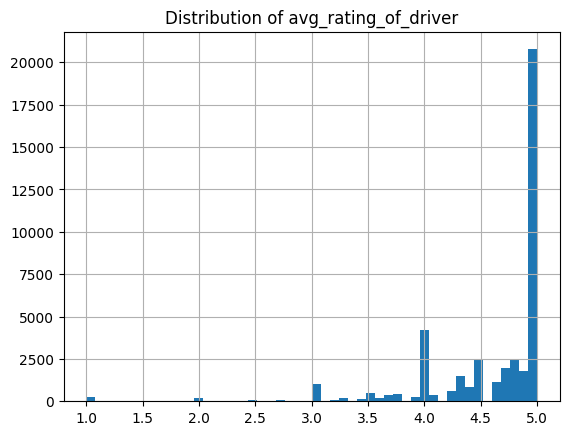

In [11]:
# Set up a quick hist plot to view distribution of the feature.
ult_df['avg_rating_of_driver'].hist(bins = 50)
plt.title('Distribution of avg_rating_of_driver')
plt.show()

#### Since the Distribution is skewed (heavily) we will impute the values with the MEDIAN here.

In [12]:
# After trying to impute with the median once there seems to be a variety of different missing values formats.
# We will look to replace common missing formats with a blanket value nan, so that we can then impute using our median.

ult_df['avg_rating_of_driver'].replace(['', 'Unknown'], np.nan)

ult_df['avg_rating_of_driver'] = ult_df['avg_rating_of_driver'].fillna(ult_df['avg_rating_of_driver'].median())
ult_df['avg_rating_of_driver'].isna().sum()


0

#### Good now let's do the others.  They have just a few missing values but we will approach them the same way.

#### For the 'phone' feature since it is a categorical feature we will just use MODE imputation.

In [13]:
ult_df['phone'].replace(['', 'Unknown'], np.nan)

ult_df['phone'] = ult_df['phone'].fillna(ult_df['phone'].mode()[0])
ult_df['phone'].isna().sum()

0

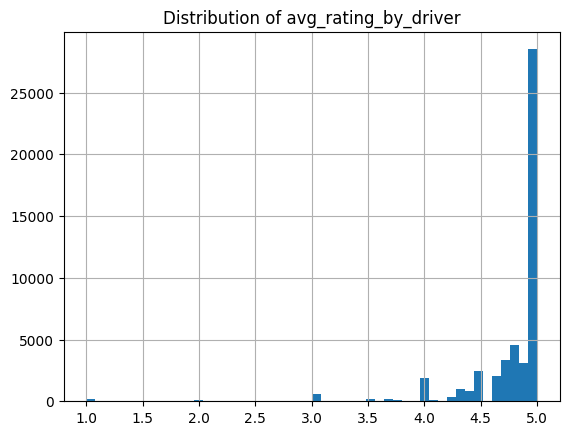

In [14]:
# As we did before let's check out a hist plot for avg_rating_by_driver.
ult_df['avg_rating_by_driver'].hist(bins = 50)
plt.title('Distribution of avg_rating_by_driver')
plt.show()

#### Just like the last hist plot we performed this one is heavily skewed as well, so we shall also perform a MEDIAN imputation on the remaining missing values.

In [15]:
# Use the same format as used before where we assign replacement for np.nan just in case since we have seen other formats.
ult_df['avg_rating_by_driver'].replace(['', 'Unknown'], np.nan)

ult_df['avg_rating_by_driver'] = ult_df['avg_rating_by_driver'].fillna(ult_df['avg_rating_by_driver'].median())
ult_df['avg_rating_by_driver'].isna().sum()


0

#### We have finished cleaning the ult_df dataset now at this point, examining it and imputing missing values with satisfactory methods.  Let's now proceed with part 2 of the exercise.

## Part 2: Experiment and Metrics Design

#### In this section we are given a 'what-if' scenario and asked questions to answer.  Posted below is the script to refer back to:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the
observation
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

#### I will answer accordingly with the number and letter that corresponds with the given question.

#### 1.  The first metric that came to mind would be the **percentage increase in cross-city trips**, as since we are talking about two specific cities one on each side of this till bridge and wanting to know how reimbursement of tolls effects resulting bridge crossings, then a metric relating to that seems logical at this time.  Also its very measurable and easily tracked, not only before the toll reimbursement but after.

#### 2.  An experiment I would look to conduct for this scenario would be something like a **RCT (Randomized Control Trial)**, where the drivers would be split into two groups.  One of the groups is a treatment group that receives ful reimbursement for cross-city trips and the other group is a control group that does not receive any reimbursement for their trips.

#### 2a.  I would implement this experiment over a fixed period of time, enough to be able to see results.  I would look to establish this test for at least a month, and maybe a period of at least 90 days so that I can see meaningful changes in user behavior.  In order to prepare for testing I would collect data for cross-city trips for a few weeks before the experiment takes place, and then of course during the experiment.

#### 2b.  For testing I would choose **t-testing** or ANOVA, though likely just t-testing.  I would compare the average number of cross-city trips in the treatment group versus the control group.

#### 2c.  As far as interpreting results I would look at the p-value and its threshold (naturally 0.05), with the base hypothesis that if the p-value is below this threshold than the toll reimbursement does have a statistically significant effect on increasing cross-city trips.  I will also want to examine our key metric we established in our percentage of cross-city trips to see if the reimbursement had any meaningful impact.  For recommendations if there are significant increases in cross-city trips due to the reimbursement I would then recomment implementing the toll reimbursement program to increase driver availability in both cities.  If however there is no significant effect that is observed, other recommendations might be passed such as surge pricing bonuses or guaranteed earnings for cross-city trips.  Such recommendations will need to be looked into further of course.

## Part 3: Predictive Modeling

####

#### Let's pick back up where we left off by taking a look at some basic EDA (Exploratory Data Analysis) on our features to see what they are telling us in our ult_df dataset.  We will look for any trends or comparisons between different sets of the features, with the goal of creating new features and knowing which of our current features will be more important to our model when we get to that stage in the process soon.  We will also create our target feature for part 3 in re

#### A great place to start is by doing a correlation heatmap as it will tell you some of the relationships between numeric features, but only the numeric features.  Categorical features won't be included in this.

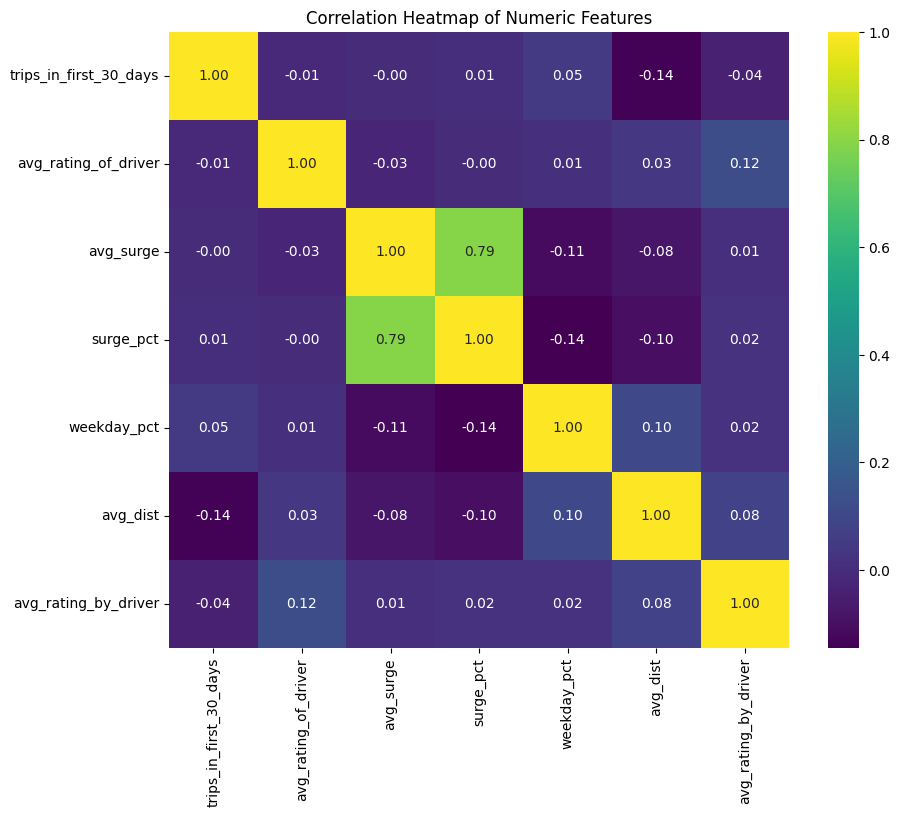

In [35]:
# We need to make sure only the numeric features are included so we don't throw an error.
numeric_df = ult_df.select_dtypes(include = ['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis', fmt = '.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#### So the above tells us a few things.  Most of the features in this dataset show correlations close to zero, which means that the features are not linearly related to each other, or rather they are likely independent of one another.  Another observation is that the highest correlation is between the two 'surge' features in avg_surge and surge_pct.  Since they both related to surge pricing and measuring similar things we can review to see if we really need both of these features in our dataset going forward or if we can reduce collinearity by removing one.  Since none of these features are highly correlated we can look to combine some features through feature engineering to create more powerful ones.  We will look into this through the remaining EDA phase as well as exploration on categorical features. 